# PENGEMBANGAN DAN PENGUJIAN


## PENGEMBANGAN

### Import Library

In [ ]:
import pymc as pm
import numpy as np
import arviz as az
import xarray as xr
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import scipy.stats as st
import math

from pytensor.tensor import TensorVariable
from typing import Optional, Tuple
from pymc.distributions.dist_math import check_parameters
from pymc.distributions.shape_utils import rv_size_is_none

In [ ]:
sampler_kwargs = {
    "chains": 4,
    "cores": 4,
    "return_inferencedata": True,
    "random_seed": 42,
}

### Definisi Fungsi Untuk CustomDist

In [ ]:
def logp(y: TensorVariable, mu: TensorVariable, sigma: TensorVariable, alpha: TensorVariable):
    omega = (1 + (1 / alpha))**(alpha + 1) / np.sqrt(2 * np.pi)
    epart = -pt.log(alpha) - (omega / sigma * (y - mu))

    logpdf = pt.switch(
        pt.eq(y, -np.inf),
        -np.inf,
        pt.log(omega) - pt.log(sigma) - (omega / sigma * (y - mu)) - ((alpha + 1) * pt.log1pexp(epart))
    )
    return check_parameters(
        logpdf,
        alpha > 0,
        sigma > 0,
        msg=f"alpha must be more than 0, sigma must be more than 0"
    )

def logcdf(y: TensorVariable, mu: TensorVariable, sigma: TensorVariable, alpha: TensorVariable, **kwargs):
    omega = (1+(1/alpha))**(alpha+1)/np.sqrt(2*np.pi)
    epart = -pt.log(alpha) - (omega/sigma*(y-mu))
    logcdf= -alpha*pt.log1pexp(epart)
    return check_parameters(
        logcdf,
        alpha > 0,
        sigma > 0,
        msg=f"alpha must more than 0, sigma must more than 0",
    )

def moment(rv, size, mu: TensorVariable, sigma: TensorVariable, alpha: TensorVariable):
    omega = (1+(1/alpha))**(alpha+1)/np.sqrt(2*np.pi)
    moment= mu + sigma/omega*(pt.digamma(alpha)-pt.digamma(1)-pt.log(alpha))
    if not rv_size_is_none(size):
        moment = pt.full(size, moment)
    return moment

def random(
      mu: np.ndarray | float,
      sigma: np.ndarray | float,
      alpha: np.ndarray | float,
      rng = np.random.default_rng(),
      size: Optional[Tuple[int]]=None,
    ):
    if sigma <= 0:
        raise ValueError("sigma must more than 0")
    if alpha <= 0:
        raise ValueError("alpha must more than 0")
    u = rng.uniform(low=0, high=1, size=size)
    omega = (1+(1/alpha))**(alpha+1)/np.sqrt(2*np.pi)
    random = mu - sigma/omega*(np.log(alpha)+np.log((u**(-1/alpha))-1))
    return np.asarray(random)

class msnburr:
    def main(name:str, mu, sigma, alpha, observed=None, **kwargs):
        return pm.CustomDist(
            name,
            mu, sigma, alpha,
            logp=logp,
            logcdf=logcdf,
            random=random,
            moment=moment,
            observed=observed,
            **kwargs
        )

    def dist(mu, sigma, alpha, **kwargs):
        return pm.CustomDist.dist(
            mu, sigma, alpha,
            logp=logp,
            logcdf=logcdf,
            random=random,
            moment=moment
        )

### Urgensi Modifikasi Rumus

In [ ]:
def logp_asli(y: TensorVariable, mu: TensorVariable, sigma: TensorVariable, alpha: TensorVariable):
    omega = (1+(1/alpha))**(alpha+1)/np.sqrt(2*np.pi)
    epart = -omega/sigma*(y-mu)

    logpdf = pt.switch(
        pt.eq(y, -np.inf),
        -np.inf,
        pt.log(omega)-pt.log(sigma)-(omega/sigma*(y-mu))-((alpha+1)*pt.log(1+pt.exp(epart)/alpha))
    )

    return check_parameters(
        logpdf,
        alpha > 0,
        sigma > 0,
        msg=f"alpha must more than 0, sigma must more than 0",
    )

class msnburr_asli:
    def dist(mu, sigma, alpha, **kwargs):
        return pm.CustomDist.dist(
            mu, sigma, alpha,
            logp=logp_asli,
        )

In [ ]:
mu = pt.scalar('mu')
sigma = pt.scalar('sigma')
alpha = pt.scalar('alpha')
value = pt.scalar('value')

rv = msnburr_asli.dist(mu=mu, sigma=sigma, alpha=alpha)
rv_logp = pm.logp(rv, value)
rv_logp_fn = pm.compile_pymc([value, mu, sigma, alpha], rv_logp)

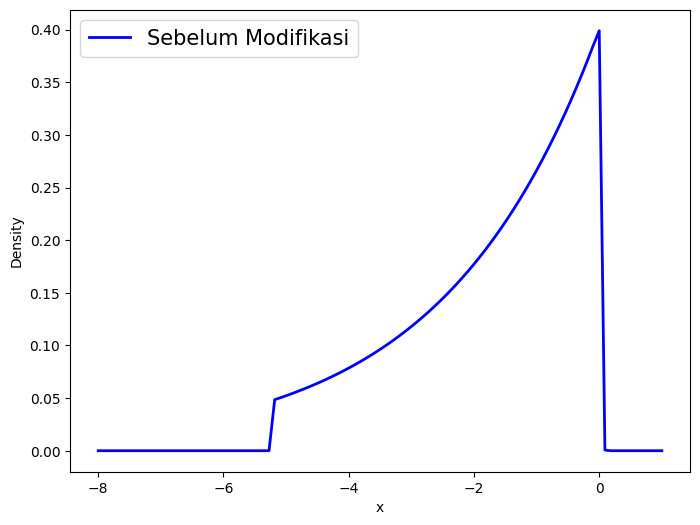

In [ ]:
# Menentukan rentang data
x = np.linspace(-8,1, 100)

# Menghitung probabilitas density
y1 = [math.exp(rv_logp_fn(value=x, mu=0.0, sigma=1, alpha=0.003)) for x in x]

# Plot density plot
plt.figure(figsize=(8,6))
plt.plot(x, y1, label='Sebelum Modifikasi', color='blue', linewidth=2.0)
plt.xlabel("x")
plt.ylabel("Density")
plt.legend(loc="upper left", fontsize=15)
plt.show()


## PENGUJIAN

### Uji Coba Program

#### PDF

In [ ]:
mu = pt.scalar('mu')
sigma = pt.scalar('sigma')
alpha = pt.scalar('alpha')
value = pt.scalar('value')

rv = msnburr.dist(mu=mu, sigma=sigma, alpha=alpha)
rv_logp = pm.logp(rv, value)

# Use .eval() for debugging
p=(rv_logp.eval({value: 0.9, mu: 0.0, sigma:10.0, alpha:1.0}))
print(math.exp(p))

# Compile a function for repeated evaluations
rv_logp_fn = pm.compile_pymc([value, mu, sigma, alpha], rv_logp)
q = rv_logp_fn(value=-np.inf, mu=0, sigma=1, alpha=1)
print(math.exp(q))

0.03968921380985907
0.0


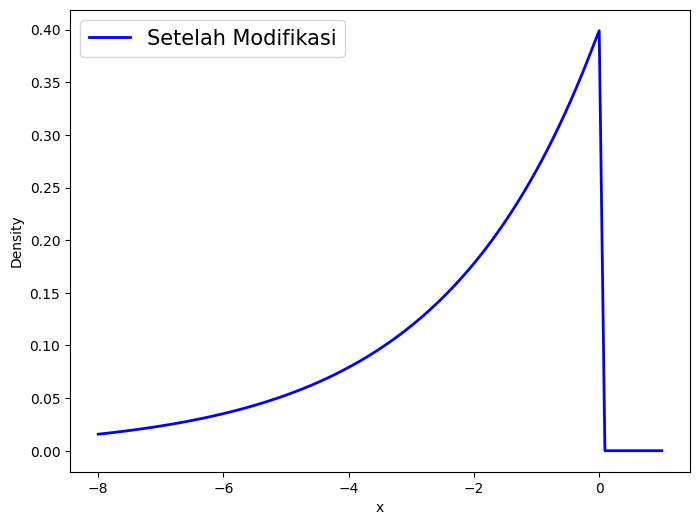

In [ ]:
# Menentukan rentang data
x = np.linspace(-8,1, 100)

# Menghitung probabilitas density
y1 = [math.exp(rv_logp_fn(value=x, mu=0.0, sigma=1, alpha=0.002)) for x in x]

# Plot density plot
plt.figure(figsize=(8,6))
plt.plot(x, y1, label='Setelah Modifikasi', color='blue', linewidth=2.0)
plt.xlabel("x")
plt.ylabel("Density")
plt.legend(loc="upper left", fontsize=15)
plt.show()


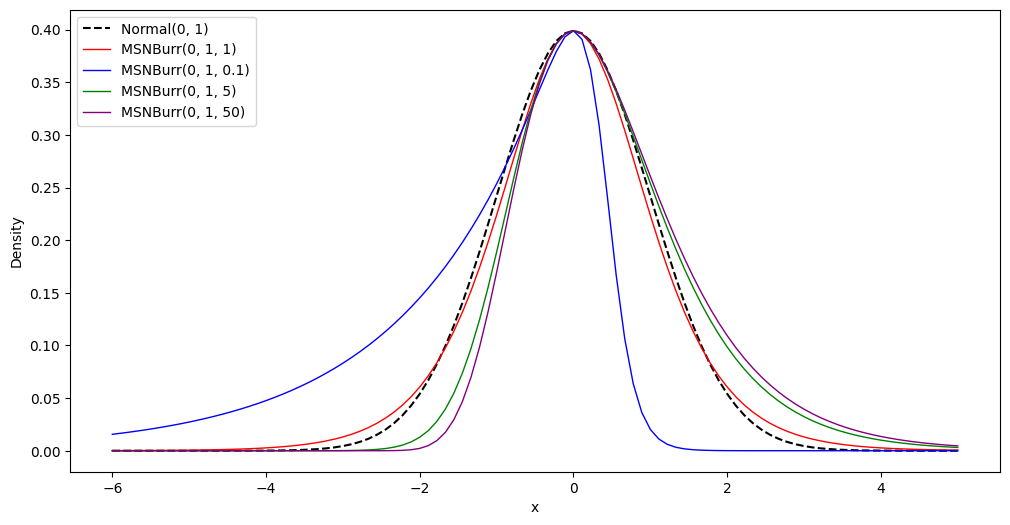

In [ ]:
mu = 0
sigma = 1
# Menentukan rentang data
x = np.linspace(-6,5, 100)

# Menghitung probabilitas density
y1 = st.norm.pdf(x, mu, sigma)
y2 = [math.exp(rv_logp_fn(value=x, mu=0.0, sigma=1.0, alpha=1.0)) for x in x]
y3 = [math.exp(rv_logp_fn(value=x, mu=0.0, sigma=1.0, alpha=0.1)) for x in x]
y4 = [math.exp(rv_logp_fn(value=x, mu=0.0, sigma=1.0, alpha=5)) for x in x]
y5 = [math.exp(rv_logp_fn(value=x, mu=0.0, sigma=1.0, alpha=50)) for x in x]

# Plot density plot
plt.figure(figsize=(12,6))
plt.plot(x, y1, label='Normal(0, 1)', color='black', linestyle='dashed')
plt.plot(x, y2, label='MSNBurr(0, 1, 1)', color='red', linewidth=1.0)
plt.plot(x, y3, label='MSNBurr(0, 1, 0.1)', color='blue', linewidth=1.0)
plt.plot(x, y4, label='MSNBurr(0, 1, 5)', color='green', linewidth=1.0)
plt.plot(x, y5, label='MSNBurr(0, 1, 50)', color='purple', linewidth=1.0)
plt.xlabel("x")
plt.ylabel("Density")
plt.legend(loc="upper left")
plt.show()


#### CDF

In [ ]:
mu = pt.scalar('mu')
sigma = pt.scalar('sigma')
alpha = pt.scalar('alpha')
value = pt.scalar('value')

rv = msnburr.dist(mu=mu, sigma=sigma, alpha=alpha)
rv_logcdf = pm.logcdf(rv, value)

# Use .eval() for debugging
p=(rv_logcdf.eval({value: -np.inf, mu: 0.0, sigma:10.0, alpha:1.0, }))
print(math.exp(p))

# Compile a function for repeated evaluations
rv_logcdf_fn = pm.compile_pymc([value, mu, sigma, alpha], rv_logcdf)
q = rv_logcdf_fn(value=0.1, mu=0, sigma=1, alpha=1.0)
print(math.exp(q))

0.0
0.5398097848851092


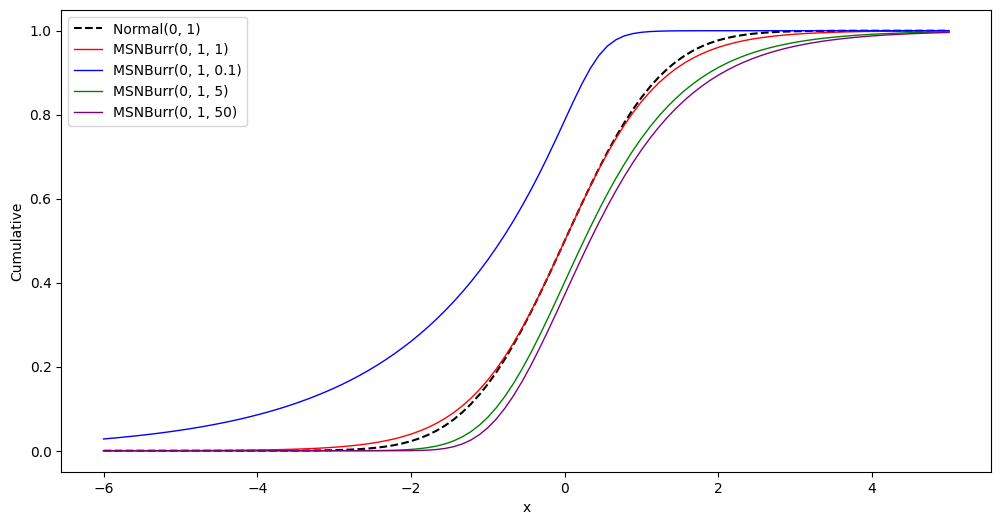

In [ ]:
mu = 0
sigma = 1
# Menentukan rentang data
x = np.linspace(-6,5, 100)

# Menghitung probabilitas density
y1 = st.norm.cdf(x, mu, sigma)
y2 = [math.exp(rv_logcdf_fn(value=x, mu=0.0, sigma=1.0, alpha=1.0)) for x in x]
y3 = [math.exp(rv_logcdf_fn(value=x, mu=0.0, sigma=1.0, alpha=0.1)) for x in x]
y4 = [math.exp(rv_logcdf_fn(value=x, mu=0.0, sigma=1.0, alpha=5)) for x in x]
y5 = [math.exp(rv_logcdf_fn(value=x, mu=0.0, sigma=1.0, alpha=50)) for x in x]

# Plot density plot
plt.figure(figsize=(12,6))
plt.plot(x, y1, label='Normal(0, 1)', color='black', linestyle='dashed')
plt.plot(x, y2, label='MSNBurr(0, 1, 1)', color='red', linewidth=1.0)
plt.plot(x, y3, label='MSNBurr(0, 1, 0.1)', color='blue', linewidth=1.0)
plt.plot(x, y4, label='MSNBurr(0, 1, 5)', color='green', linewidth=1.0)
plt.plot(x, y5, label='MSNBurr(0, 1, 50)', color='purple', linewidth=1.0)
plt.xlabel("x")
plt.ylabel("Cumulative")
plt.legend()
plt.show()


#### Momen

In [ ]:
from pymc.initial_point import make_initial_point_fn
def test_moment(mu, sigma, alpha, size):
    with pm.Model() as model:
        msnburr.main("x", mu=mu, sigma=sigma, alpha=alpha, size=size)

    fn = make_initial_point_fn(
        model=model,
        return_transformed=False,
        default_strategy="moment",
    )
    moment = fn(0)["x"]
    print(moment)

test_moment(0,0.1,2,1)


[0.0227901]


#### Random

In [ ]:
mu = 0
sigma = 1
alpha = 0.3

rv = msnburr.dist(mu, sigma, alpha)
hasilrandom = pm.draw(rv, draws=100)
hasilrandom

array([-1.83722282,  0.73912627, -1.01301583, -1.00815703,  0.10642951,
       -2.92367781, -1.29932163, -1.3802106 , -0.87157459, -0.48458172,
       -0.24892924,  0.49438271,  0.99218431, -0.13291128, -2.97132316,
       -0.246632  ,  0.66011309, -0.14646761, -1.96193515,  0.0692533 ,
        0.56026037,  1.05952724, -0.33488321,  1.60700222, -0.25370832,
       -1.76875533, -1.95514741,  0.48950223, -1.65555541, -0.17828398,
       -0.52872421, -0.50978156,  0.45608026, -0.20284099, -2.2778537 ,
       -1.15571967,  0.2512181 , -1.79404332,  0.80837895, -0.40902263,
        0.12167253,  0.02959587, -5.20964642, -2.45083832, -0.27048313,
       -1.90048526,  0.12263853, -2.61735552,  0.64103407, -0.4559268 ,
       -0.48216921,  0.80747732, -0.78203549,  0.76205569,  1.08584134,
       -2.89561626,  0.85179353,  0.6635807 , -1.06171569,  0.33830078,
       -0.52525134, -0.44757493,  0.31896876,  1.02535808, -3.21167702,
       -0.56594528, -0.59830957, -0.61060416, -3.05049747, -0.59

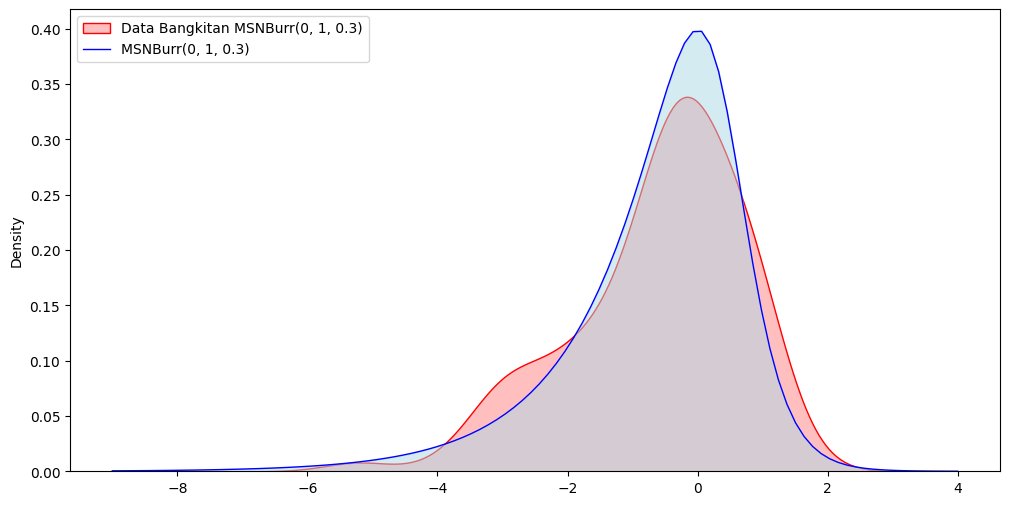

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,6))
x = np.linspace(-9, 4, 100)
y1 = sns.kdeplot(hasilrandom, fill=True, color="red", label='Data Bangkitan MSNBurr(0, 1, 0.3)')
y2 = [math.exp(rv_logp_fn(value=x, mu=0.0, sigma=1.0, alpha=0.3)) for x in x]

y1
plt.plot(x, y2, label='MSNBurr(0, 1, 0.3)', color='blue', linewidth=1.0)
plt.fill_between(x, y2, color="lightblue", alpha=0.5)
plt.legend()
plt.show()

### Validasi Output

#### PDF

In [ ]:
import pandas as pd
# Menentukan parameter yang akan digunakan
mu_grup = [-5, 0, 0.6, 9, 35]
sigma_grup = [0.1, 15, 30, 0.7]
alpha_grup = [0.4, 1, 17, 45]

# Nilai X yang akan dicari PDF dan CDFnya
x_grup = [-35.5, -5, -2.34, -10, 0, 20.22, 47, 13, 77, 5.76 ]

tabel_pdf = pd.DataFrame(columns=['X', 'mu', 'sigma', 'alpha', 'logpdf', 'PDF'])
tabel_cdf = pd.DataFrame(columns=['X', 'mu', 'sigma', 'alpha', 'logcdf', 'CDF'])

import random
for i in range(0,25):
    mu = random.choice(mu_grup)
    sigma = random.choice(sigma_grup)
    alpha = random.choice(alpha_grup)
    x = random.choice(x_grup)
    logpdf = rv_logp_fn(value=x, mu=mu, sigma=sigma, alpha=alpha)
    logcdf = rv_logcdf_fn(value=x, mu=mu, sigma=sigma, alpha=alpha)

    df_pdf = pd.DataFrame([{"X":x, "mu":mu, "sigma":sigma, "alpha":alpha, 'logpdf':np.round(logpdf, decimals=4), "PDF":np.round(math.exp(logpdf), decimals = 4)}])
    df_cdf = pd.DataFrame([{"X":x, "mu":mu, "sigma":sigma, "alpha":alpha, 'logcdf':np.round(logcdf, decimals=4), "CDF":np.round(math.exp(logcdf), decimals = 4)}])
    tabel_pdf = pd.concat([tabel_pdf, df_pdf], ignore_index=True)
    tabel_cdf = pd.concat([tabel_cdf, df_cdf], ignore_index=True)

tabel_pdf.to_csv('PDF.csv')
tabel_cdf.to_csv('CDF.csv')

In [ ]:
from scipy.integrate import quad

def msnburr_pdf(x, mu, sigma, alpha):
  rv = msnburr.dist(mu,sigma,alpha)
  rv_logp = pm.logp(rv, x)
  return math.exp(rv_logp.eval())

def pembuktian1(mu, sigma, alpha):
  integral, error = quad(msnburr_pdf, -5, 10, args=(mu, sigma, alpha))
  return integral

def pembuktian2(mu, sigma, alpha):
  integral, error = quad(msnburr_pdf, -np.inf, 0.1, args=(mu, sigma, alpha))
  return integral

integral1 = pembuktian1(0, 1, 1)
integral2 = pembuktian2(0, 1, 1)
print(integral1)
print(integral2)


0.9996573652307206
0.5398097848851094


#### Random

In [ ]:
def quantile(p, mu, sigma, alpha):
    omega = (1+(1/alpha))**(alpha+1)/np.sqrt(2*np.pi)
    q = mu - sigma/omega*(np.log(alpha)+np.log((p**(-1/alpha))-1))
    return q

p = quantile(p=0.7534389541609909,mu=0.0, sigma=10.0, alpha=1.0)
print(p)

7.0


### Validasi Hasil Estimasi Parameter


#### Bangkitkan Data

In [ ]:
data1 = msnburr.dist(mu=0, sigma=1, alpha=1)
data2 = msnburr.dist(mu=0, sigma=1, alpha=0.1)
data3 = msnburr.dist(mu=0, sigma=1, alpha=5)

hasilrandom = pm.draw(data3, draws=20000)

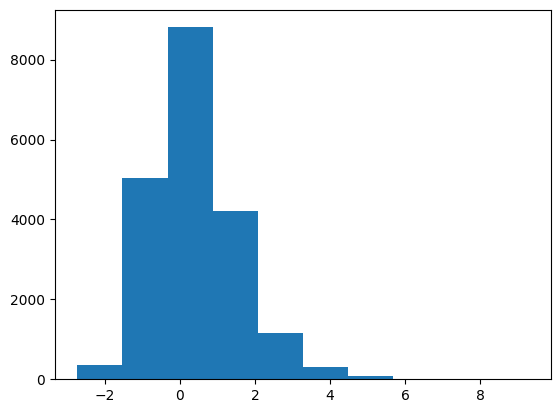

In [ ]:
plt.hist(hasilrandom)
plt.show()

#### Buat Model

In [ ]:
with pm.Model() as model1:
    mu = pm.Normal('mu',0,10)
    sigma = pm.HalfCauchy('sigma',10)
    alpha = pm.Gamma('alpha',2,0.1)

    msnburr.main(
        'MSNBurr',
        mu, sigma, alpha,
        hasilrandom
    )
with model1:
    trace_validasi = pm.sample(**sampler_kwargs)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.009,0.011,-0.010,0.032,0.000,0.000,2270.593,2518.507,1.003
sigma,0.995,0.006,0.985,1.007,0.000,0.000,2805.404,2837.056,1.001
alpha,4.914,0.346,4.265,5.604,0.007,0.005,2296.740,2332.362,1.003


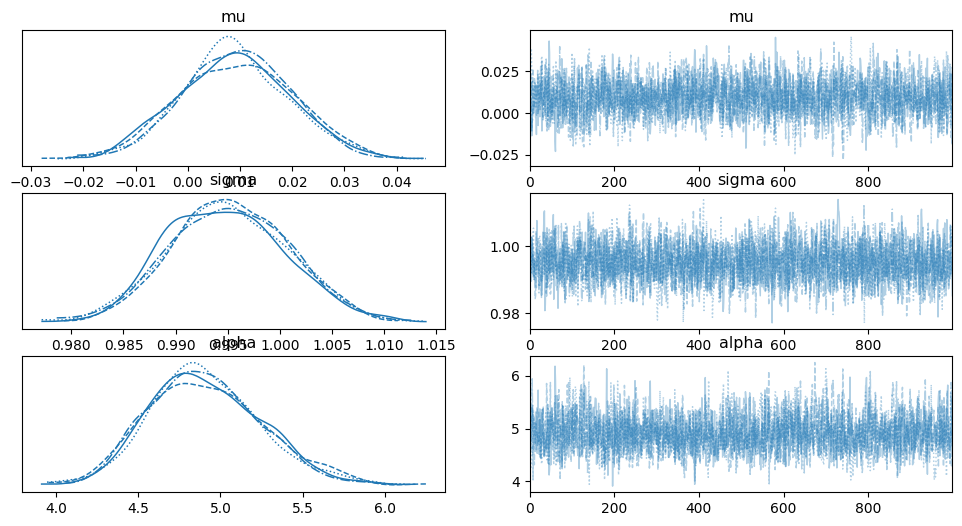

In [ ]:
az.plot_trace(trace_validasi)
az.summary(trace_validasi, round_to=3, hdi_prob=0.95)

#### Visualisasi

In [ ]:
summary = az.summary(trace_validasi, round_to=3)
mean_values = summary['mean']
print(mean_values)

mu       0.009
sigma    0.995
alpha    4.914
Name: mean, dtype: float64


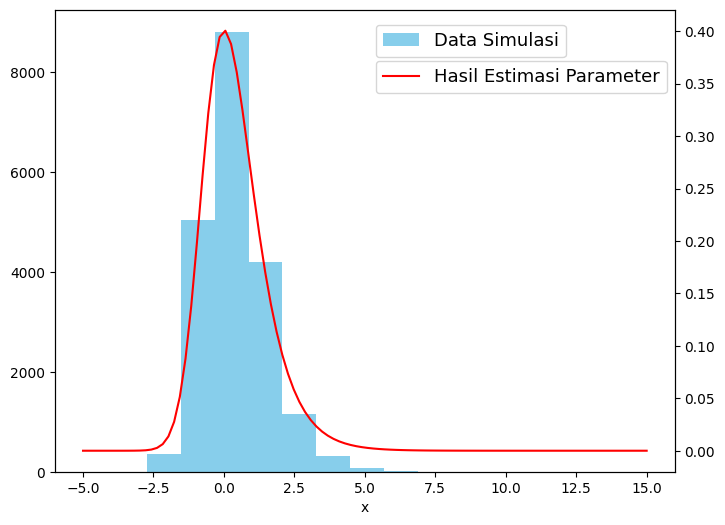

In [ ]:
x = np.linspace(-5,15, 100)
y = [math.exp(rv_logp_fn(value=x, mu=mean_values[0], sigma=mean_values[1], alpha=mean_values[2])) for x in x]

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(hasilrandom, label='Data Simulasi', color='skyblue')
ax.set_xlabel("x")
legend = plt.legend(fontsize=13)
legend.set_bbox_to_anchor((0.775, 0.87), transform=plt.gcf().transFigure)

ax2 = ax.twinx()
ax2.plot(x, y, label='Hasil Estimasi Parameter', color='red', linewidth=1.5)
legend = plt.legend(fontsize=13)
legend.set_bbox_to_anchor((0.515, 0.81), transform=plt.gcf().transFigure)
plt.show()


# EVALUASI

## Prior


<ipython-input-22-e2d9426cc82e>:3: RuntimeWarning: invalid value encountered in scalar divide
  skewness = (special.polygamma(2, alpha)-special.polygamma(2, 1))/(special.polygamma(1, alpha)+special.polygamma(1, 1))**(3/2)


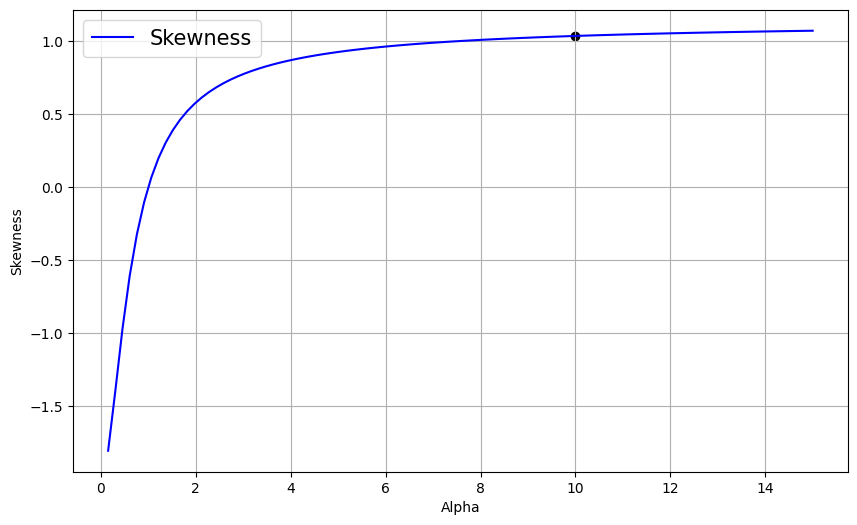

In [ ]:
import scipy.special as special
def skewness(alpha):
    skewness = (special.polygamma(2, alpha)-special.polygamma(2, 1))/(special.polygamma(1, alpha)+special.polygamma(1, 1))**(3/2)
    return skewness

x = np.linspace(0,15, 100)
y = [skewness(x) for x in x]
x1 = 10
y1 = skewness(x1)

# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Skewness', color='blue')
plt.scatter(x1, y1, color='black')
plt.xlabel('Alpha')
plt.ylabel('Skewness')
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

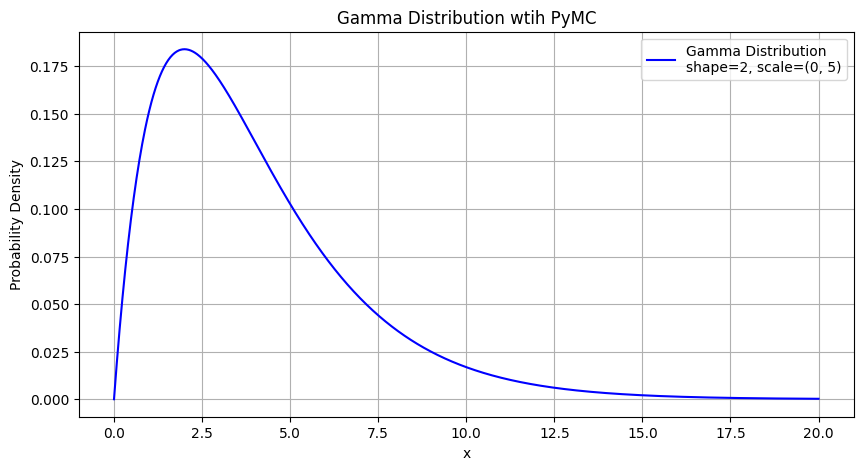

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

value = pt.scalar("value")
rv = pm.Gamma.dist(alpha=2, beta=0.5)
rv_logp = pm.logp(rv, value)
rv_logp_fn = pm.compile_pymc([value], rv_logp)

x = np.linspace(0, 20, 1000)
y = [math.exp(rv_logp_fn(value=x)) for x in x]

# Plot density plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, label=f'Gamma Distribution\nshape={2}, scale={0,5}', color='blue')
plt.title('Gamma Distribution wtih PyMC')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

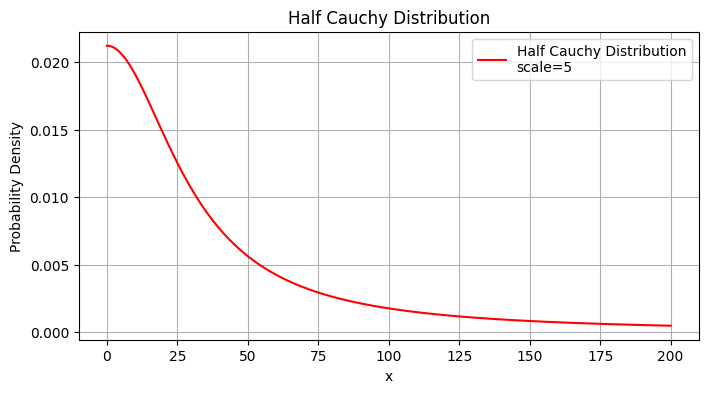

In [ ]:
from scipy.stats import halfcauchy
x = np.linspace(0, 200, 1000)
y = halfcauchy.pdf(x, scale=30)

# Membuat plot
plt.figure(figsize=(8, 4))
plt.plot(x, y, label='Half Cauchy Distribution\nscale=5', color='red')
plt.title('Half Cauchy Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


## AHH


### Histogram


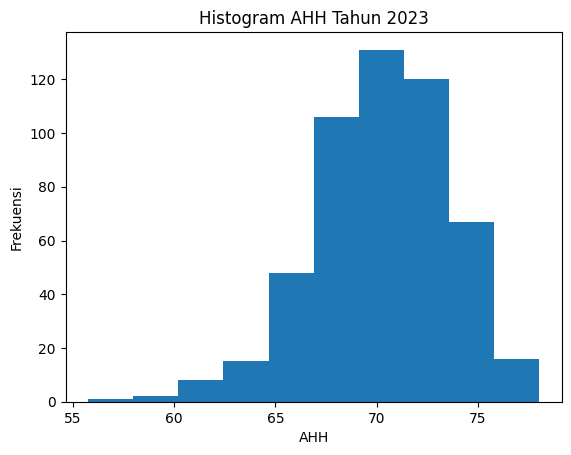

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel("AHH Indo 2023.xlsx")
data = df.iloc[:, 1]
plt.hist(data)
plt.xlabel("AHH")
plt.ylabel("Frekuensi")
plt.title("Histogram AHH Tahun 2023")
plt.show()

### Uji Normalitas dan Kemencengan


In [ ]:
from scipy import stats

print("AHH Tahun 2023")
# Normality test (Shapiro-Wilk test)
shapiro_test_result = stats.shapiro(data)
print(f"Shapiro-Wilk test (p-value): {shapiro_test_result[1]}")
# Skewness test
skewness = stats.skew(data)
print(f"Skewness: {skewness}")

AHH Tahun 2023
Shapiro-Wilk test (p-value): 2.857939398381859e-05
Skewness: -0.508231845109571


### Estimasi Parameter

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,70.257,0.148,69.983,70.562,0.002,0.002,4536.930,3029.554,1.000
sigma,3.398,0.108,3.191,3.604,0.002,0.001,4158.052,3186.445,1.003


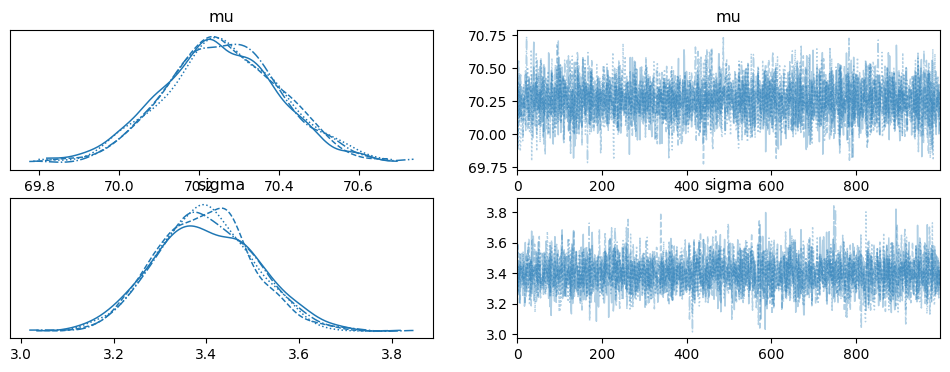

In [ ]:
with pm.Model() as modelNormal:
    mu = pm.Normal('mu',74,5)
    sigma = pm.HalfCauchy('sigma',5)

    pm.Normal('Regresi Normal', mu=mu, sigma=sigma, observed=data)
    traceNormal = pm.sample(**sampler_kwargs)

az.plot_trace(traceNormal)
az.summary(traceNormal, round_to=3, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,70.831,0.247,70.362,71.309,0.006,0.004,1896.126,2134.214,1.002
sigma,2.984,0.115,2.762,3.202,0.002,0.002,2310.479,2627.666,1.003
alpha,0.679,0.117,0.476,0.920,0.003,0.002,1848.684,2006.150,1.001


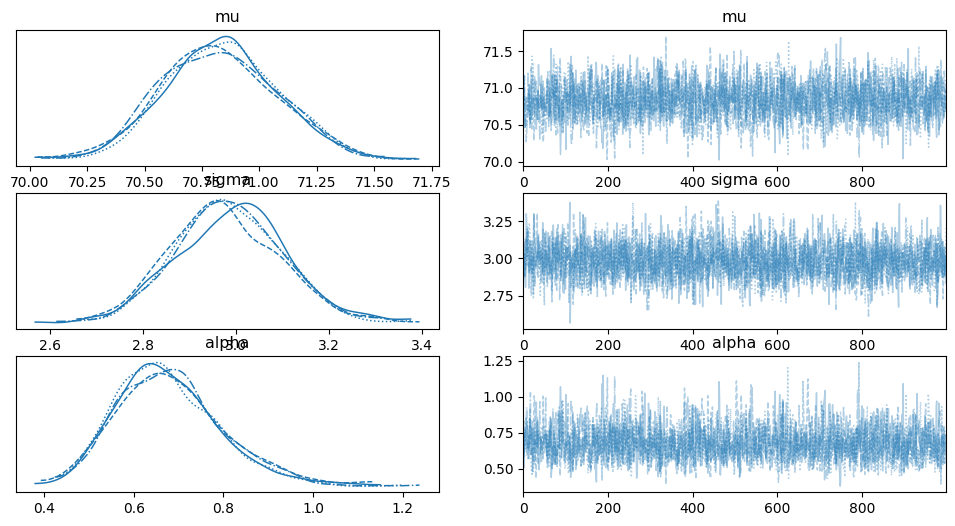

In [ ]:
with pm.Model() as modelAHH:
    mu = pm.Normal('mu',74,5)
    sigma = pm.HalfCauchy('sigma',5)
    alpha = pm.Gamma('alpha',2,0.5)

    msnburr.main(
        'MSNBurr',
        mu, sigma, alpha,
        data
    )
    traceMSNBurr = pm.sample(**sampler_kwargs)

az.plot_trace(traceMSNBurr)
az.summary(traceMSNBurr, round_to=3, hdi_prob=0.95)

### Karakteristik Data

In [ ]:
summary1 = az.summary(traceNormal, round_to=3)
summary2 = az.summary(traceMSNBurr, round_to=3)
mean_values_normal = summary1['mean']
mean_values = summary2['mean']
print("Parameter Distribusi Normal")
print(mean_values_normal)
print("Parameter Distribusi MSNBurr")
print(mean_values)

Parameter Distribusi Normal
mu       70.257
sigma     3.398
Name: mean, dtype: float64
Parameter Distribusi MSNBurr
mu       70.831
sigma     2.984
alpha     0.679
Name: mean, dtype: float64


In [ ]:
import scipy.special as special
def expected_value(mu, sigma, alpha):
    omega = (1+(1/alpha))**(alpha+1)/np.sqrt(2*np.pi)
    expected_value = mu + sigma/omega*(special.polygamma(0, alpha)-special.polygamma(0, 1)-np.log(alpha))
    return expected_value
def variance(sigma, alpha):
    omega = (1+(1/alpha))**(alpha+1)/np.sqrt(2*np.pi)
    variance = (sigma**2)/(omega**2)*(special.polygamma(1, alpha)+special.polygamma(1,1))
    return variance
def skewness(alpha):
    skewness = (special.polygamma(2, alpha)-special.polygamma(2, 1))/(special.polygamma(1, alpha)+special.polygamma(1, 1))**(3/2)
    return skewness

In [ ]:
mu = mean_values[0]
sigma = mean_values[1]
alpha = mean_values[2]

expected_value_ = expected_value(mu, sigma, alpha)
variance_ = variance(sigma, alpha)
mode_ = mu
skewness_ = skewness(alpha)

print("Expected value (E(x)):", expected_value_)
print("Variance (Var(x)):", variance_)
print("Mode:", mode_)
print("Skewness:", skewness_)

Expected value (E(x)): 70.31301654901269
Variance (Var(x)): 12.362982308689961
Mode: 70.831
Skewness: -0.4640157282413766


### Visualisasi


In [ ]:
mu = pt.scalar('mu')
sigma = pt.scalar('sigma')
alpha = pt.scalar('alpha')
value = pt.scalar('value')

rv = msnburr.dist(mu=mu, sigma=sigma, alpha=alpha)
rv_logp = pm.logp(rv, value)
rv_logp_fn = pm.compile_pymc([value, mu, sigma, alpha], rv_logp)

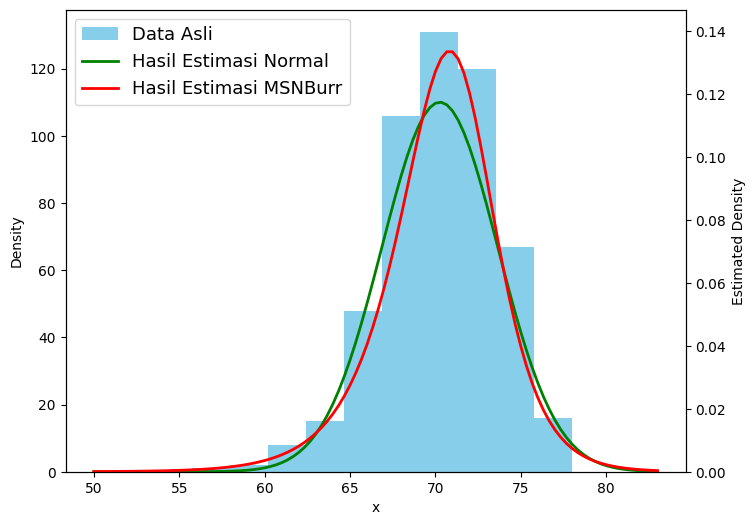

In [ ]:
from scipy.stats import norm
x = np.linspace(50, 83, 100)
y = [math.exp(rv_logp_fn(value=xi, mu=mean_values[0], sigma=mean_values[1], alpha=mean_values[2])) for xi in x]
y1 = [norm.pdf(x, mean_values_normal[0], mean_values_normal[1] ) for x in x]

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(data, label='Data Asli', color='skyblue')

ax2 = ax.twinx()
ax2.plot(x, y1, label='Hasil Estimasi Normal', color='green', linewidth=2)
ax2.plot(x, y, label='Hasil Estimasi MSNBurr', color='red', linewidth=2)
ax2.set_ylim([0, max(y) * 1.1])

ax.set_xlabel("x")
ax.set_ylabel("Density")
ax2.set_ylabel("Estimated Density")
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=13)

plt.show()


## Simulasi Regresi

In [ ]:
x1 = np.random.normal(0,1,20000)
x2 = np.random.normal(0,1,20000)
b0 = 0.63
b1 = 0.78
b2 = 0.003
ycap = b0 + b1*x1 + b2*x2
eps1 = np.random.normal(0,1,20000)
eps2 = pm.draw(msnburr.dist(0,1,1), draws=20000)
eps3 = pm.draw(msnburr.dist(0,1,0.1), draws=20000)
eps4 = pm.draw(msnburr.dist(0,1,5), draws=20000)
y = ycap + eps4

In [ ]:
with pm.Model() as simulasiregresi:
    sigma = pm.HalfCauchy('sigma',5)
    alpha = pm.Gamma('alpha',2,0.5)
    b0 = pm.Normal('b0',0, 0.5)
    b1 = pm.Normal('b1',0, 0.5)
    b2 = pm.Normal('b2',0, 0.5)

    eps = b0 + b1*x1 + b2*x2

    msnburr.main('Simulasi Regresi', mu=eps, sigma=sigma, alpha=alpha, observed=y)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,0.634,0.011,0.614,0.654,0.000,0.000,4041.202,3008.044,1.001
b1,0.787,0.007,0.773,0.801,0.000,0.000,4608.535,2732.559,1.001
b2,0.010,0.007,-0.004,0.023,0.000,0.000,4340.376,3099.108,1.002
sigma,0.997,0.006,0.986,1.008,0.000,0.000,4216.340,3164.665,1.001
alpha,4.907,0.335,4.301,5.590,0.005,0.004,3823.373,2856.771,1.001


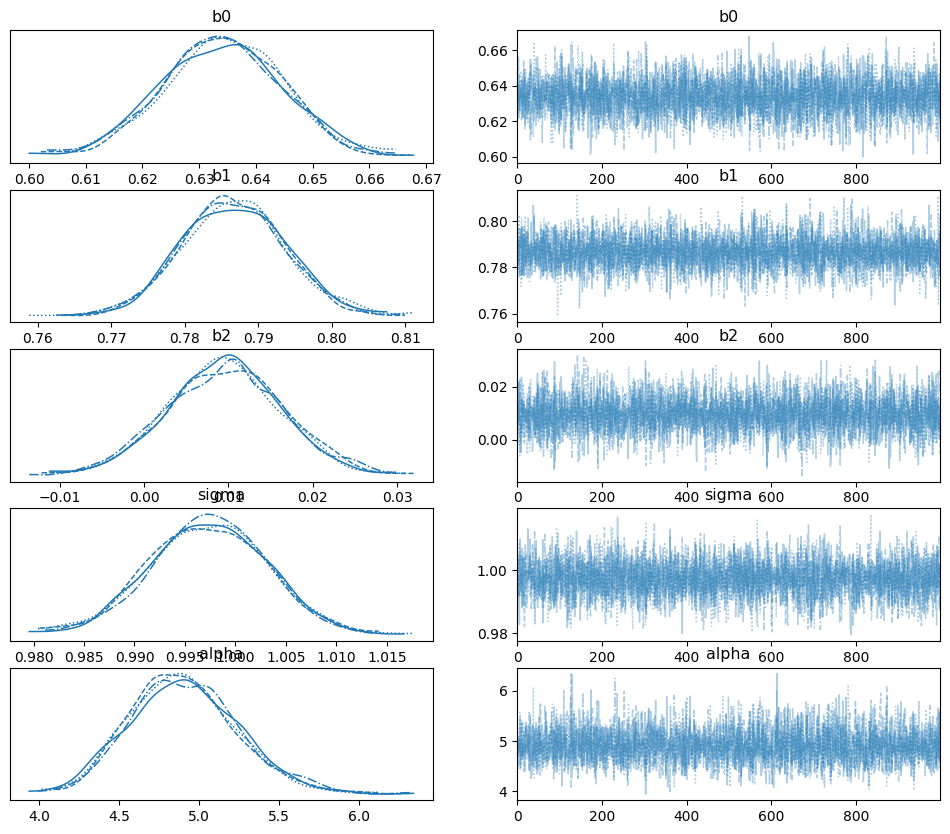

In [ ]:
with simulasiregresi:
    trace_coba = pm.sample(**sampler_kwargs)

az.plot_trace(trace_coba)
az.summary(trace_coba, round_to=3, hdi_prob=0.95)

## PDRB


### Load Data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.metrics import mean_squared_error

data1 = pd.read_excel("DATA.xlsx")
data = data1.iloc[:,1:3]
data.head()

,Y,X1
0,1.409717e+08,2394994
1,5.735288e+08,7197374
2,1.826291e+08,2688164
3,5.295330e+08,3168929
4,1.617300e+08,1797819


In [ ]:
y = np.log(data["Y"])
x1 = np.log(data["X1"])

### Cek dengan OLS


In [ ]:
# 1. Mengimpor Pustaka
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.metrics import mean_squared_error

# 2. Menyiapkan Data
X = np.log(data[["X1"]])
Y = np.log(data["Y"])

# 3. Menambahkan Kolom Konstan
X = sm.add_constant(X)

# 4. Membuat Model Regresi OLS dan Melakukan Fitting
model = sm.OLS(Y, X).fit()

# 5. Melihat Ringkasan Hasil Regresi
print(model.summary())

# 6. Menghitung Residual
residuals = model.resid

y_pred = model.predict(X)
# 7. Menghitung Mean Squared Error (MSE)
mse = mean_squared_error(Y, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     100.7
Date:                Tue, 09 Jul 2024   Prob (F-statistic):           2.08e-11
Time:                        10:28:41   Log-Likelihood:                -28.012
No. Observations:                  34   AIC:                             60.02
Df Residuals:                      32   BIC:                             63.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8084      1.415      3.398      0.0

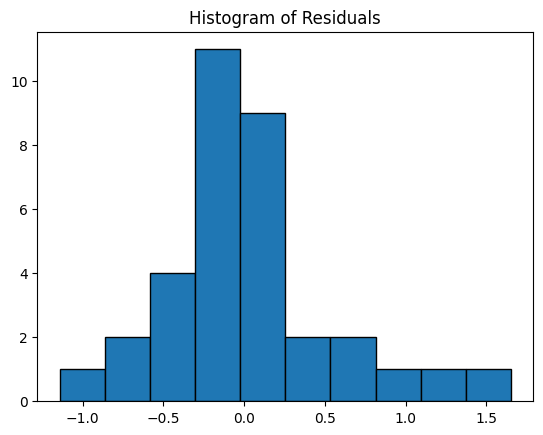

In [ ]:
plt.hist(residuals, edgecolor='black')  # Customize bins, color, and transparency
plt.title('Histogram of Residuals')
plt.show()

### Uji Normalitas

In [ ]:
import scipy.stats as stats
shapiro_test_result = stats.shapiro(data)
print(f"Shapiro-Wilk test (p-value): {shapiro_test_result[1]}")

Shapiro-Wilk test (p-value): 5.577621494550801e-14


### Uji Linieritas

In [ ]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector
import rpy2.robjects.numpy2ri

utils = importr('utils')
utils.install_packages('tseries')

# Aktifkan konversi numpy
rpy2.robjects.numpy2ri.activate()

# Impor paket tseries dari R
tseries = importr('tseries')

(as ‘lib’ is unspecified)


































	‘/tmp/RtmpD1RDtZ/downloaded_packages’



In [ ]:
# Convert numpy arrays to R vectors
x1_r = FloatVector(x1)
# x2_r = FloatVector(x2)
# x3_r = FloatVector(x3)
y_r = FloatVector(y)

In [ ]:
# Gabungkan x1, x2, x3 menjadi matriks di R
# x_combined_r = ro.r['cbind'](x1_r, x2_r)

# Menjalankan Terasvirta Test
# terasvirta_test_result = tseries.terasvirta_test(x_combined_r, y_r)
terasvirta_test_result = tseries.terasvirta_test(x1_r,y_r)

# Mendapatkan hasil
f_statistic = terasvirta_test_result.rx2('statistic')[0]
p_value = terasvirta_test_result.rx2('p.value')[0]

# Menampilkan hasil
print(f'F-statistic: {f_statistic}, p-value: {p_value}')

F-statistic: 2.177438226438964, p-value: 0.3366474248970288


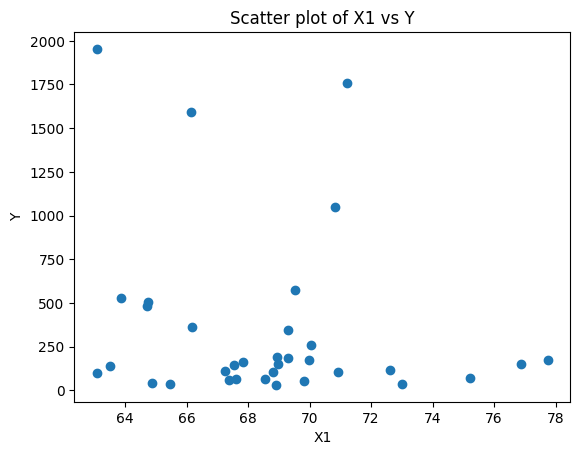

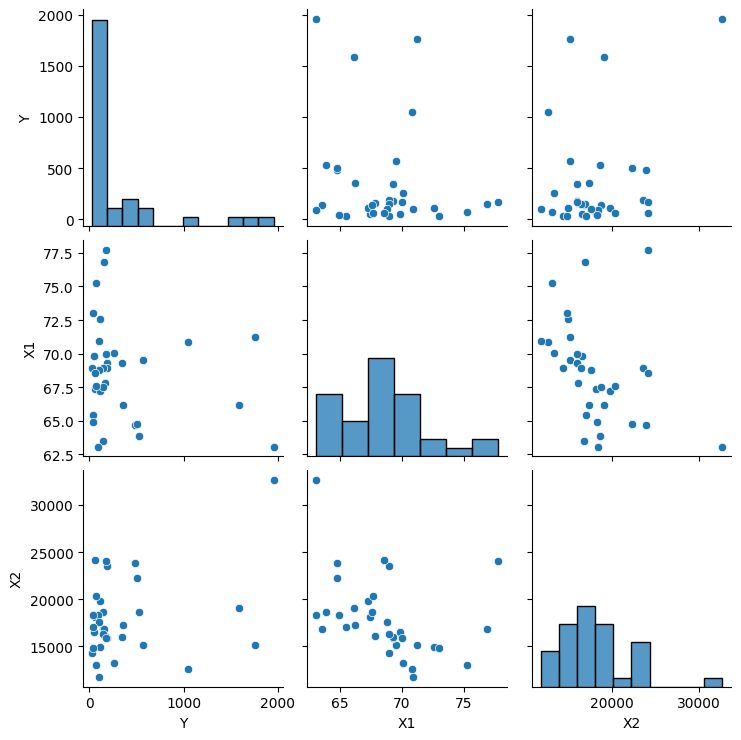

           Y        X1        X2
Y   1.000000 -0.194834  0.319050
X1 -0.194834  1.000000 -0.371716
X2  0.319050 -0.371716  1.000000


In [ ]:
df = pd.DataFrame(data)

# Scatter plot X1 vs Y
plt.scatter(df['X1'], df['Y'])
plt.xlabel('X1')
plt.ylabel('Y')
plt.title('Scatter plot of X1 vs Y')
plt.show()

# Pair plot untuk semua variabel
sns.pairplot(df)
plt.show()

# Correlation matrix
correlation_matrix = df.corr()
print(correlation_matrix)

### Regresi Bayesian Normal

#### Build Model

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'b0'}>, <Axes: title={'center': 'b0'}>],
       [<Axes: title={'center': 'b1'}>, <Axes: title={'center': 'b1'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

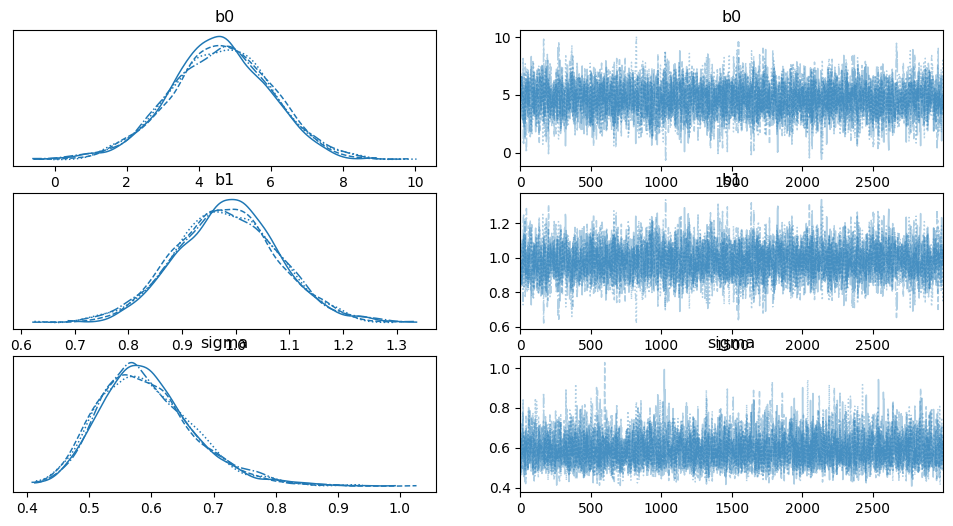

In [ ]:
with pm.Model() as regresinormal:
    # Prior
    sigma = pm.HalfCauchy('sigma',5)
    b0 = pm.Normal('b0',0, 5)
    b1 = pm.Normal('b1',0, 1)
    # b2 = pm.Normal('b2',0, 0.5)

    eps = b0 + b1*x1

    pm.Normal('Regresi Normal', mu=eps, sigma=sigma, observed=y)
    step = pm.NUTS(target_accept=0.95, max_treedepth=15)
    trace = pm.sample(3000, step=step, chains=4, cores=4,return_inferencedata=True, random_seed=42, tune=2000)

az.plot_trace(trace)

In [ ]:
az.summary(trace, round_to=5, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,4.60045,1.41608,1.74167,7.31209,0.02426,0.01719,3429.53014,3544.72753,1.00064
b1,0.98386,0.09667,0.79770,1.17675,0.00166,0.00117,3428.21311,3504.07617,1.00059
sigma,0.59245,0.07740,0.45187,0.74706,0.00118,0.00085,4497.17138,4160.42451,1.00119


In [ ]:
summary = az.summary(trace, round_to=3)
mean_values = summary['mean']
print("Nilai mean dari setiap variabel:")
print(mean_values)

Nilai mean dari setiap variabel:
b0       4.600
b1       0.984
sigma    0.592
Name: mean, dtype: float64


#### Posterior Predictive Check

In [ ]:
with regresinormal:
    # Draw samples from posterior predictive
    post_pred = pm.sample_posterior_predictive(trace)
    trace.extend(post_pred)

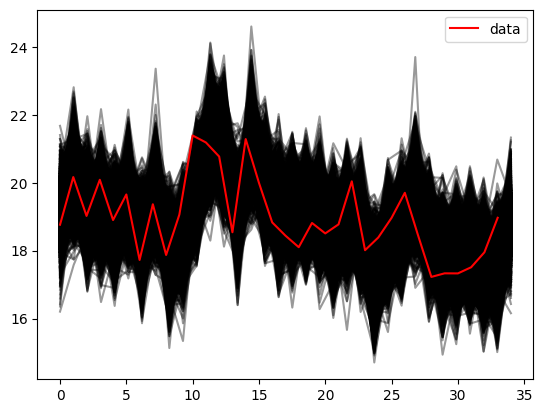

In [ ]:
Y = np.log(data["Y"])
fig, ax = plt.subplots()
x = xr.DataArray(np.linspace(0, 34, 34), dims=["plot_dim"])
y = trace.posterior_predictive['Regresi Normal']

ax.plot(x, y.stack(sample=("chain","draw")).values.squeeze(), c="k", alpha=0.4)
ax.plot(Y, color="r", label="data")
ax.legend();

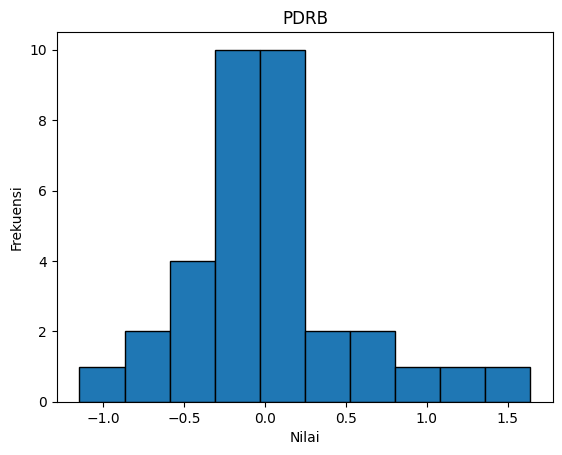

In [ ]:
y = np.log(data["Y"])
x1 = np.log(data["X1"])
y_pred = mean_values[0] + mean_values[1]*x1
residuals = y - y_pred
plt.hist(residuals, edgecolor='black')  # Customize bins, color, and transparency
plt.title('PDRB')
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')
plt.show()

### Regresi Bayesian MSNBurr

#### Build Model

array([[<Axes: title={'center': 'b0'}>, <Axes: title={'center': 'b0'}>],
       [<Axes: title={'center': 'b1'}>, <Axes: title={'center': 'b1'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

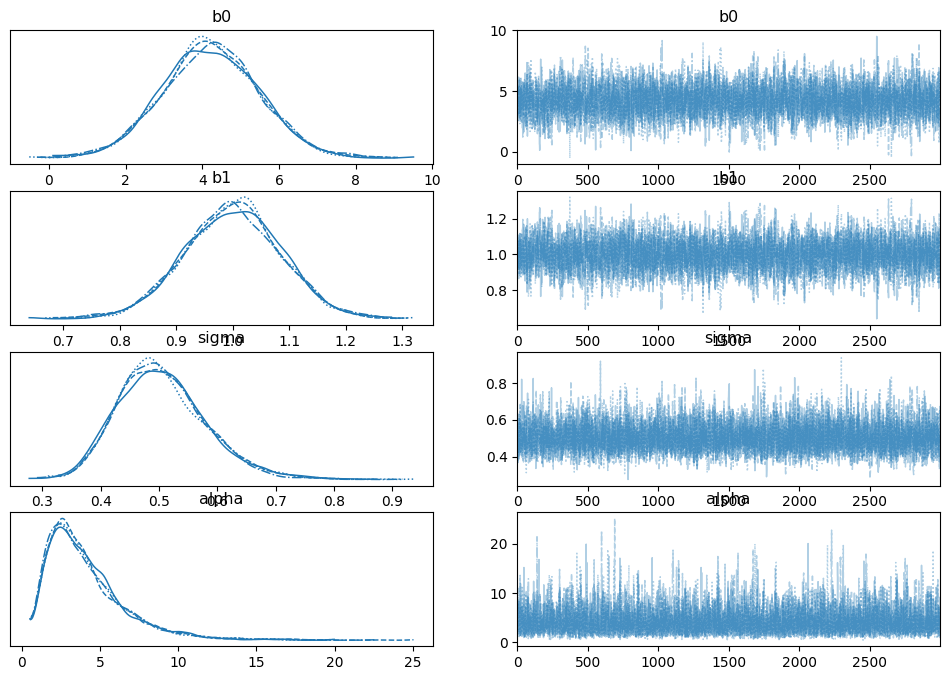

In [ ]:
y = np.log(data["Y"])
with pm.Model() as regresimsnburr:
    sigma = pm.HalfCauchy('sigma',5)
    alpha = pm.Gamma('alpha',2,0.5)
    b0 = pm.Normal('b0',0, 5)
    b1 = pm.Normal('b1',0, 1)

    eps = b0 + b1*x1

    msnburr.main('Regresi MSNBurr', mu=eps, sigma=sigma, alpha=alpha, observed=y)
    step = pm.NUTS(target_accept=0.95, max_treedepth=15)
    trace2 = pm.sample(3000, step=step, chains=4, cores=4,return_inferencedata=True, random_seed=42, tune=2000)

az.plot_trace(trace2)

In [ ]:
az.summary(trace2, round_to=5, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,4.21369,1.26904,1.75125,6.68905,0.02082,0.01490,3741.01180,4505.86417,1.00024
b1,0.99953,0.08615,0.82850,1.16258,0.00141,0.00100,3756.96508,4354.51046,1.00021
sigma,0.50532,0.07590,0.36637,0.65612,0.00101,0.00071,5622.77631,5693.80706,1.00100
alpha,4.12709,2.56648,0.70143,9.15966,0.03321,0.02539,6639.02648,6187.80545,1.00011


In [ ]:
summary = az.summary(trace, round_to=3)
mean_values = summary['mean']
print("Nilai mean dari setiap variabel:")
print(mean_values)

Nilai mean dari setiap variabel:
b0       4.600
b1       0.984
sigma    0.592
Name: mean, dtype: float64


#### Posterior Predictive Check

In [ ]:
with regresimsnburr:
    # Draw samples from posterior predictive
    post_pred = pm.sample_posterior_predictive(trace2)
    trace2.extend(post_pred)

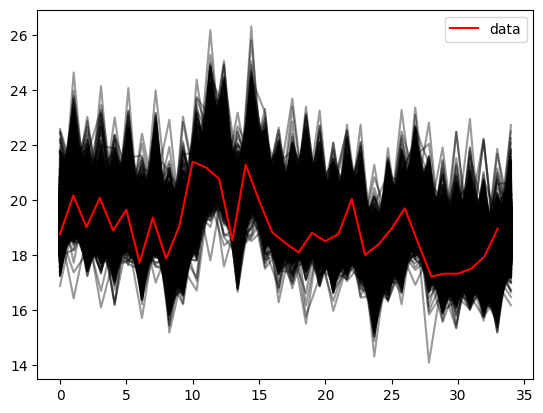

In [ ]:
Y = np.log(data["Y"])
fig, ax = plt.subplots()
x = xr.DataArray(np.linspace(0, 34, 34), dims=["plot_dim"])
y = trace2.posterior_predictive['Regresi MSNBurr']

ax.plot(x, y.stack(sample=("chain","draw")).values.squeeze(), c="k", alpha=0.4)
ax.plot(Y, color="r", label="data")
ax.legend();

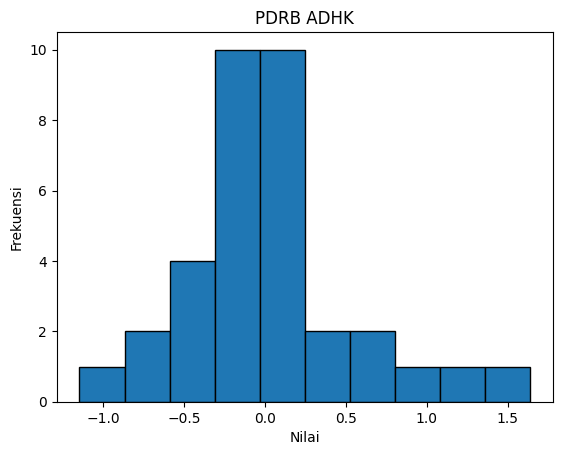

In [ ]:
y = np.log(data["Y"])
x1 = np.log(data["X1"])
y_pred = mean_values[0] + mean_values[1]*x1
residuals = y - y_pred
plt.hist(residuals, edgecolor='black')  # Customize bins, color, and transparency
plt.title('PDRB ADHK')
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')
plt.show()

### Cek Kebaikan Model

In [ ]:
with regresinormal:
    pm.compute_log_likelihood(trace)

waic = az.waic(trace)
loo = az.loo(trace)

print(waic)
print(loo)

<ipython-input-29-bdf6c820c1f9>:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  waic = az.waic(trace)
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
<ipython-input-29-bdf6c820c1f9>:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loo = az.loo(trace)


Computed from 12000 posterior samples and 34 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -31.29     5.53
p_waic        3.07        -

There has been a warning during the calculation. Please check the results.
Computed from 12000 posterior samples and 34 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -31.35     5.56
p_loo        3.13        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       34  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [ ]:
with regresimsnburr:
    pm.compute_log_likelihood(trace2)

waic = az.waic(trace2)
loo = az.loo(trace2)

print(waic)
print(loo)

Computed from 12000 posterior samples and 34 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -29.07     5.50
p_waic        3.09        -

There has been a warning during the calculation. Please check the results.
Computed from 12000 posterior samples and 34 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -29.15     5.54
p_loo        3.17        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       34  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



<ipython-input-30-a7d856bf8188>:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  waic = az.waic(trace2)
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
<ipython-input-30-a7d856bf8188>:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loo = az.loo(trace2)


# TAMBAHAN


Density Plot dari Distribusi Normal dan Logistik Amemiya

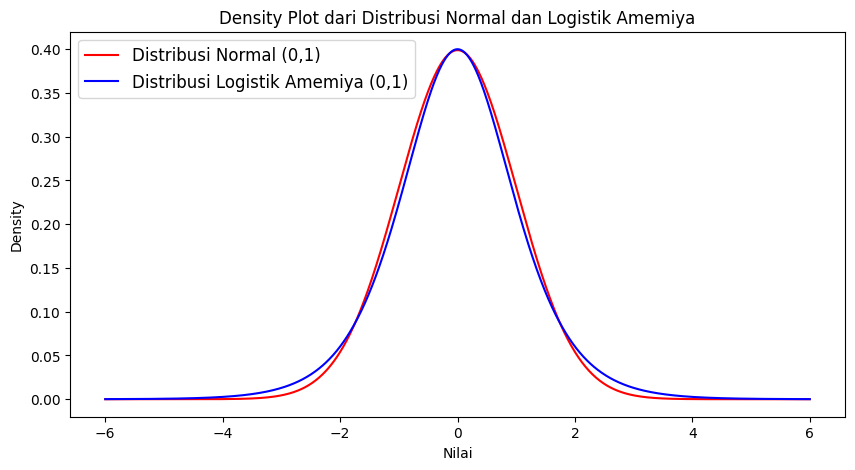

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

# Membuat array nilai x untuk plot
x = np.linspace(-6, 6, 1000)
k =1.6

pdf_logit = k*np.exp(-k*x)/(1+np.exp(-k*x))**2
pdf_norm = norm.pdf(x, loc=0, scale=1)

# Membuat density plot menggunakan matplotlib
plt.figure(figsize=(10, 5))
plt.plot(x, pdf_norm, label='Distribusi Normal (0,1)', color='red')
plt.plot(x, pdf_logit, label='Distribusi Logistik Amemiya (0,1)', color='blue')
# plt.fill_between(x, pdf_logit, alpha=0.5, color='blue')
# plt.fill_between(x, pdf_norm, alpha=0.5, color='red')

# Menambahkan judul dan label
plt.title('Density Plot dari Distribusi Normal dan Logistik Amemiya')
plt.xlabel('Nilai')
plt.ylabel('Density')
plt.legend(loc="upper left", fontsize=12)
# Menampilkan plot
plt.show()
